<h1 align="center">⚾ MLB Player Trends: Insights from SQL and Python Analytics</h1>

<h4 align="center" style="margin-top:-10px;">
    A data-driven deep dive into player origins, team spending, and performance trends
</h4>

<h5 align="center"> 
    <strong>By: Shreeyasha Pandey</strong>
</h5>

---

## ☰ Project Overview

This project uncovers trends and patterns in Major League Baseball (MLB) player data using **SQL** for data extraction and **Python** for analysis and visualization.

We dive into where players come from, which schools consistently produce MLB talent, how teams differ in spending and player retention, and what player attributes—like height, weight, and batting/throwing handedness—reveal about positional roles. We also take a closer look at player longevity to understand career span trends across the league.

Whether you're a recruiter, coach, or data enthusiast, the aim is to surface insights that bridge performance, business decisions, and player development within professional baseball.

- **Tools Used:** PostgreSQL, Python (pandas, matplotlib, seaborn), Jupyter Notebook  
- **Key Themes:** Player origins by state/school, team salary and retention trends, player longevity, player attribute comparision

---

## ☰ Data Source & Structure

The data for this project is stored in a **PostgreSQL relational database**, organized into the following key tables:

- **`players`** – Biographical information on each MLB player  
- **`salaries`** – Annual salary records by player and team  
- **`schools`** – School attendance records, including years attended  
- **`schools_details`** – School metadata (name, city, state, country)

Throughout the notebook, we use **SQL queries** (stored in the project’s [`Queries/`](./Queries) folder) to extract and filter relevant slices of data for analysis and visualization.

---


## 1. Libraries and Database Setup <a class="anchor" id="1-libraries-and-database-setup"></a>

### Import Libraries

In [455]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyfonts import load_font
from IPython.display import display, Markdown
from highlight_text import fig_text
import matplotlib.gridspec as gridspec
from matplotlib.colors import to_rgb

# Environment Variables and DB Connection
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine

### Global Styles and Themes**

In [473]:
# Set global seaborn styles
sns.set_style("white", {"axes.spines.right": False, "axes.spines.top": False, 
                        "axes.spines.left": True, "axes.spines.bottom": True})

# Notebook Color plalette
palette_sequential = sns.color_palette("YlOrBr_r")
palette_core = {"primary_dark": "#8f3e2e", "primary_light": "#e3a049", "secondary_gray": "#696969", "highlight_red": "#c30101", 
                "highlight_green": "#3b6e4d", "avline": "#a52a2a"}

palette_qualitative = ["#c30101", "#561600", "#de6600", "#769c50", "#40532d", 
                       "#1e2b11", "#a52a2a", "#e07b3b", "#ffbc78", "#c4d6b0", 
                       "#627d41", "#364c2a", "#8f3e2e", "#e3a049", "#3b6e4d", "#b4cba6"]

# Notebook Fonts
font_regular = load_font("https://github.com/google/fonts/blob/main/ofl/librebaskerville/LibreBaskerville-Regular.ttf?raw=true")
font_bold = load_font("https://github.com/google/fonts/blob/main/ofl/librebaskerville/LibreBaskerville-Bold.ttf?raw=true")

### Create Database Engine

In [12]:
# Load from .env file
load_dotenv()

# Fetch credentials from environment
DB_NAME = os.getenv("DB_NAME")
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST", "localhost")
DB_PORT = os.getenv("DB_PORT", "5432")

# Create SQLAlchemy engine
engine = create_engine(f'postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}')

---
## 2. Loading the Dataset
In this section, we load all relevant tables from the PostgreSQL database using SQL queries. Each table is briefly previewed to provide an overview of its structure and contents. SQL will also be used throughout the notebook for advanced filtering and data extraction.

To streamline our workflow, we define three utility functions:

- `preview_table`: Displays the first and last few rows of a DataFrame with an ellipsis in between to give a quick overview of its structure without overwhelming detail.

- `load_table`: Executes a basic SQL query to load an entire table from the PostgreSQL database into a pandas DataFrame.

- `load_sql_query`: Reads and executes a SQL query from a file and resturns the result as a DataFrame.

In [15]:
def preview_table(df, table_name, n=2):
    """Preview the first and last few rows of a DataFrame with ellipsis in between."""
    ellipsis_row = pd.DataFrame({col: '...' for col in df.columns}, index=['...'])
    
    display(Markdown(f"**Preview of `{table_name}`:**"))
    preview_df = pd.concat([df.head(n), ellipsis_row, df.tail(n)])
    display(preview_df)

def load_table(table_name):
    """Load a table from the database into a pandas DataFrame."""
    query = f"SELECT * FROM {table_name};"
    return pd.read_sql(query, con=engine)

def load_sql_query(filename):
    """Load a SQL query from a file and returns the results as a DataFrame."""
    with open(f"../Queries/{filename}.sql") as f:
        query = f.read()
    return pd.read_sql(query, con=engine)

We now load all relevant tables used in this analysis:

In [17]:
# Load all tables in the database
players = load_table("players")
salaries = load_table("salaries")
school_details = load_table("school_details")
schools = load_table("schools")

---
## 3. School-Based Analysis

In this section, we analyze the role of educational institutions in producing Major League Baseball (MLB) players. Using data from the `schools` and `school_details` tables, we aim to explore patterns in player origins based on schools, states, and time periods. 

In [19]:
# Preview the tables
preview_table(schools, "schools")
preview_table(school_details, "school_details")

**Preview of `schools`:**

,playerid,schoolid,yearid
0,aardsda01,pennst,2001
1,aardsda01,rice,2002
...,...,...,...
17348,zuvelpa01,stanford,1979
17349,zuvelpa01,stanford,1980


**Preview of `school_details`:**

,schoolid,name_full,city,state,country
0,abilchrist,Abilene Christian University,Abilene,TX,USA
1,adelphi,Adelphi University,Garden City,NY,USA
...,...,...,...,...,...
1205,yale,Yale University,New Haven,CT,USA
1206,youngst,Youngstown State University,Youngstown,OH,USA


### 📑 Section Goals:
The following key questions will guide our analysis:

1. **Top Player-Producing Schools:**  
   Identify the top 5 schools that have produced the largest number of MLB players.

2. **Geographic Distribution:**  
   Analyze the locations of these schools — specifically, the states they are based in — to understand regional trends.

3. **Evolution of School Contributions Over Time:**  
   Determine how many schools produced MLB players over the decades. This helps capture the breadth of institutions involved across different eras.

4. **Decade-Wise Top Player-Producing Schools:**  
   Identify the top schools that produced the most players in each decade. This will highlight how school influence may have shifted over time.

This analysis will help uncover historical and regional influences in player development and could potentially inform scouting strategies or historical retrospectives.

## 3.1 Top Player-Producing Schools

In this subsection, we identify the **top 5 schools** that have produced the highest number of MLB players. This helps highlight institutions with strong baseball programs or historical pipelines to the major leagues.


***SQL Query:***
```sql
-- Retrieve the top 5 schools that have produced the most MLB players
SELECT sd.name_full AS school_name, s.players_produced
FROM school_details AS sd
RIGHT JOIN (
    SELECT schoolid, COUNT(DISTINCT playerid) AS players_produced
    FROM schools
    GROUP BY schoolid
) AS s
ON sd.schoolid = s.schoolid
ORDER BY s.players_produced DESC
LIMIT 5;


***Query Result:***

In [23]:
# Run query and preview result
df_top_five_schools = load_sql_query("3.1_top_player_producers")
display(df_top_five_schools)

,school_name,players_produced
0,University of Texas at Austin,107
1,University of Southern California,105
2,Arizona State University,101
3,Stanford University,86
4,University of Michigan,76


### 🔍 Player-Producing Schools Insights:

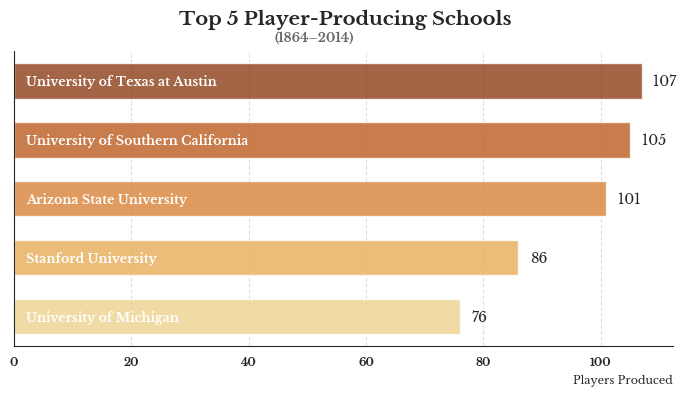

In [475]:
# Initialize layout and visualize a bar plot
fig, ax = plt.subplots(figsize=(7, 4))
ax.grid(axis="x", linestyle="--", alpha=0.6)

sns.barplot(data=df_top_five_schools, x="players_produced", y="school_name", 
            hue="school_name", palette=palette_sequential[:5], ax=ax, width=0.6, alpha=0.8)

# Title
title = "Top 5 Player-Producing Schools"
fig.suptitle(title, ha="center", font=font_bold, fontsize=14)

# Subtitle
subtitle = f"({schools["yearid"].min()}–{schools["yearid"].max()})"
fig.text(0.40, 0.90, subtitle, fontsize=9, color="dimgrey", font=font_bold)

# Labels and ticks
plt.xlabel("Players Produced", font=font_regular, fontsize=8, loc="right")
plt.ylabel("")
plt.xticks(font=font_bold, size=8)
plt.yticks([])

# Add value and school name as bar labels
for index, row in df_top_five_schools.iterrows():
    # Value label outside the bar
    ax.text(row["players_produced"] + 2.0, index, str(row["players_produced"]),
            va="center", font=font_regular, fontsize=10, fontweight="semibold")

    # School name inside the bar
    ax.text(2, index, row["school_name"], va="center", ha="left",
            font=font_bold, fontsize=9, color="white", fontweight="semibold")

plt.tight_layout()
plt.show()

**UT Austin and USC lead the list**, each producing over 100 players, while ASU follows closely with 101 players. The top five schools have established themselves as consistent pipelines for MLB talent.

---
### 3.2 Geographic Distribution
In this section, we analyze the geographic distribution of MLB players based on the states where they attended school. The goal is to identify which states have historically produced the highest number of professional baseball players.

***SQL Query:***
```sql
-- Retrieve the top 5 states where most players attended school
SELECT sd.state, COUNT(DISTINCT playerid) AS num_players
FROM schools AS s
LEFT JOIN school_details AS sd
ON s.schoolid = sd.schoolid
GROUP BY sd.state
ORDER BY num_players DESC
LIMIT 3;

***Query Result:***

In [29]:
# Run query and preview result
df_top_five_states = load_sql_query("3.2_top_five_states")
display(df_top_five_states)

,state,num_players
0,CA,1247
1,TX,536
2,FL,473
3,NC,284
4,PA,284


### 🌎 Geographic Insights:

In [31]:
def custom_barplot(df, x_axis, y_axis, hue, y_label, x_label="", annote=True):
    # Barplot and grid
    ax.grid(axis="y", linestyle="--", alpha=0.6)
    sns.barplot(data=df, x=x_axis, y=y_axis,
                hue=hue, palette="YlOrBr_r", edgecolor="black", width=0.5, alpha=0.8, legend=False)
    
    
    # Labels and ticks
    plt.ylabel(y_label, font=font_bold, fontsize=8, loc="bottom", color="dimgrey")
    plt.xlabel(x_label, font=font_bold, fontsize=8, loc="left", color="dimgrey")
    plt.yticks(font=font_bold, size=8)
    plt.xticks(font=font_bold, size=8)
    
    # Annotate bar labels
    if annote:
        padding = df[y_axis].max() / 100
        for index, value in enumerate(df[y_axis]):
            ax.text(x=index, y=value + padding, s=f"{value:,}", ha="center", va="bottom", font=font_bold, fontsize=10, weight="bold")
            
    plt.tight_layout()

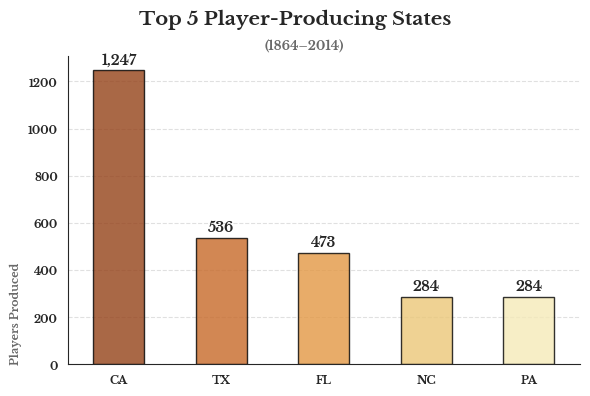

In [32]:
# Initialize layout and visualize a bar plot
fig, ax = plt.subplots(figsize=(6, 4))

# Title
fig.suptitle("Top 5 Player-Producing States", ha="center", font=font_bold, fontsize=14)

# Subtitle
subtitle = f"({schools["yearid"].min()}–{schools["yearid"].max()})"
fig.text(0.45, 0.88, subtitle, fontsize=9, color="dimgrey", font=font_bold)
custom_barplot(df=df_top_five_states, x_axis="state", y_axis="num_players", hue="state", y_label="Players Produced")

California clearly leads as the top state for producing MLB players, with 1,247 players — more than double the count from Texas (536) and Florida (473). This significant margin highlights **California as a dominant pipeline** for baseball talent in the U.S.

---
### 3.3 Evolution of School Contributions Over Time
This section explores how the number of schools contributing to MLB talent has shifted across decades. By tracking school representation over time, we can observe whether talent development has become more concentrated among a few institutions or broadened across many.

***SQL Query:***
```sql
-- Count the number of unique schools that produced MLB players per decade
SELECT FLOOR(yearid / 10) * 10 AS decade,
       COUNT(DISTINCT schoolid) AS num_schools
FROM schools
GROUP BY decade
ORDER BY decade;


***Query Result:***

In [36]:
# Run query and preview result
df_schools_per_decade = load_sql_query("3.3_schools_per_decade")
df_schools_per_decade.set_index("decade", inplace=True)
preview_table(df_schools_per_decade, "df_schools_per_decade")

**Preview of `df_schools_per_decade`:**

,num_schools
1860,2
1870,14
...,...
2000,372
2010,57


### 📈 Evolution of School Contributions Insights:

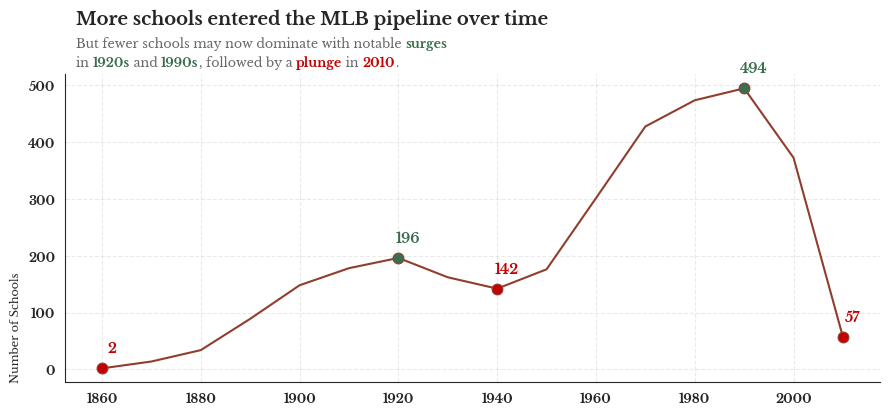

In [491]:
# Initialize layout and plot a line chart
fig, ax = plt.subplots(figsize=(9, 4))
ax.grid(True, linestyle="--", alpha=0.4)
sns.lineplot(data=df_schools_per_decade, x="decade", y="num_schools", linewidth=1.5, color=palette_core["primary_dark"], alpha=1.0, ax=ax)

# Title
fig.text(0.09, 0.99, "More schools entered the MLB pipeline over time", fontsize=13, font=font_bold)

# Subtitle
subtitle = "But fewer schools may now dominate with notable <surges> \nin <1920s> and <1990s>, followed by a <plunge> in <2010>."

fig_text(x=0.09, y=0.92,
         s=subtitle, ha="left", va="center",
         fontsize=9, fontproperties=font_regular, color="dimgray",
         highlight_textprops=[
             {"color": palette_core["highlight_green"], "fontproperties": font_bold},
             {"color": palette_core["highlight_green"], "fontproperties": font_bold},
             {"color": palette_core["highlight_green"], "fontproperties": font_bold},
             {"color": palette_core["highlight_red"], "fontproperties": font_bold},
             {"color": palette_core["highlight_red"], "fontproperties": font_bold}
         ]
        )

# Labels
plt.ylabel("Number of Schools", font=font_regular, fontsize=8, loc="bottom")
plt.xlabel("")
plt.yticks(font=font_bold, size=9)
plt.xticks(font=font_bold, size=9)

# Highlight key decades
highlight_decades = [1860, 1920, 1940, 1990, 2010]
highlight_df = df_schools_per_decade[df_schools_per_decade.index.isin(highlight_decades)]

for decade, row in highlight_df.iterrows():
    value = row["num_schools"]
    marker_color = palette_core["highlight_green"] if decade in [1920, 1990] else palette_core["highlight_red"]
    
    ax.text(x=decade + 2, y=value + 20, s=f"{value}", 
            ha="center", va="bottom", font=font_bold, fontsize=10, color=marker_color)

    # Highlight the line markers
    ax.scatter(decade, row["num_schools"], 
           color=marker_color, zorder=5, s=60, edgecolor=palette_core["primary_dark"], linewidth=0.8)

plt.tight_layout()
plt.show()

From the 1860s through the early 20th century, the number of schools contributing players to Major League Baseball grew steadily. 

This growth **accelerated significantly starting in the 1950s**, reaching a **peak in the 1990s** with close to 500 contributing schools — marking a period of broad national participation. 

**The trend reversed post-1990s**, with a notable decline by the 2010s. This suggests a shift in the talent pipeline, concentrating MLB recruitment into select institutions.

---
### 3.4 Decade-Wise Top Player-Producing Schools
This section explores how the top MLB talent-producing schools have evolved across decades. By identifying the leading school for each decade based on the number of unique players produced, we uncover shifts in institutional dominance and the changing landscape of collegiate baseball influence over time.

***SQL Query:***
```sql
-- Assign each record a decade based on the yearid
WITH school_by_decade AS (
    SELECT *, FLOOR(yearid / 10) * 10 AS decade
    FROM schools
),

-- Count unique players per school per decade and rank schools by player count
school_ranking AS (
    SELECT 
        decade, 
        schoolid, 
        COUNT(DISTINCT playerid) AS num_players,
        ROW_NUMBER() OVER (PARTITION BY decade ORDER BY COUNT(DISTINCT playerid) DESC) AS school_rank
    FROM school_by_decade
    GROUP BY decade, schoolid
)

-- Get the top-ranked school for each decade with its name and number of players
SELECT 
    CONCAT(sr.decade, 's') AS decade, 
    sd.name_full AS school_name, 
    sr.num_players
FROM school_ranking AS sr
LEFT JOIN school_details AS sd ON sr.schoolid = sd.schoolid
WHERE school_rank = 1
ORDER BY sr.decade DESC;



***Query Result:***

In [42]:
# Run query and preview result
df_top_schools_per_decade = load_sql_query("3.4_top_school_by_decade")
preview_table(df_top_schools_per_decade, "df_top_school_by_decadee")

**Preview of `df_top_school_by_decadee`:**

,decade,school_name,num_players
0,1860s,fordham,1
1,1860s,villanova,1
...,...,...,...
19,2000s,longbeach,23
20,2010s,florida,5


In [43]:
# Sort DataFrame by frequency of decade per school
df_top_schools_per_decade = (
    df_top_schools_per_decade
    .assign(school_decade_count=lambda df: df["school_name"].map(df["school_name"].value_counts()))
    .sort_values(by=["school_decade_count", "num_players"], ascending=[False, False])
)

### 🔍 Decade-Wise Domninace Insights:

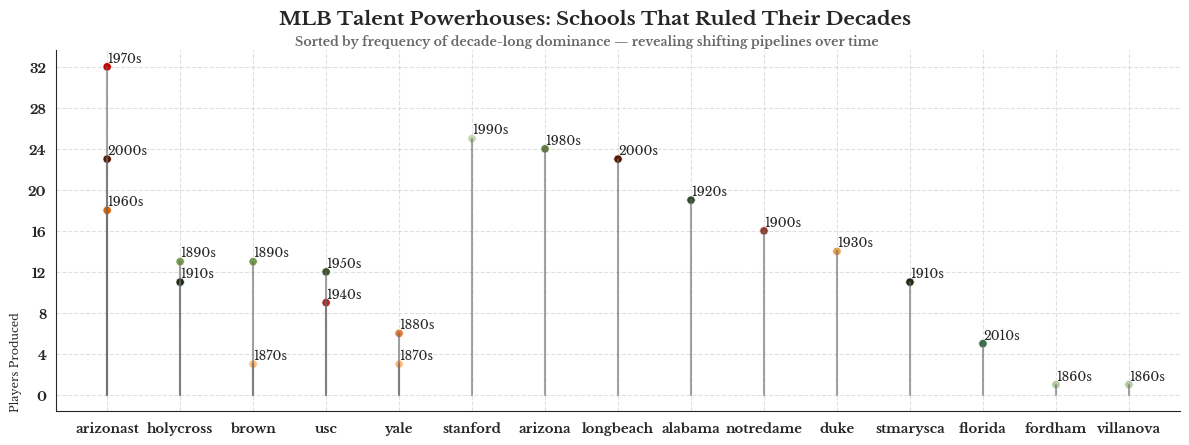

In [493]:
## Initialize layout 
fig, ax = plt.subplots(figsize=(12, 4.5))
ax.grid(True, linestyle="--", alpha=0.6)

# Plot lolipop plot
for i, row in df_top_schools_per_decade.iterrows():
    x_axis = row["school_name"]
    y_axis = row["num_players"]
    sns.scatterplot(data=df_top_schools_per_decade, x="school_name", y="num_players", hue="decade", 
                    palette=palette_qualitative, ax=ax, legend=False) # scatter plot
    ax.plot([x_axis,x_axis], [0,y_axis], color=palette_core["secondary_gray"], alpha=0.6) # lineplot
    ax.text(x_axis, y_axis + 0.5, row["decade"],
            font=font_regular, fontsize=9) # annote with decade

# Title
fig.suptitle("MLB Talent Powerhouses: Schools That Ruled Their Decades", ha="center", font=font_bold, fontsize=14)

# Subtitle
fig.text(0.25, 0.90, "Sorted by frequency of decade-long dominance — revealing shifting pipelines over time", 
         fontsize=9, color="dimgrey", font=font_bold)
   
# Labels and ticks
plt.xticks(font=font_bold, size=9.5)
plt.xlabel("")
plt.ylabel("Players Produced", font=font_regular, fontsize=8, loc="bottom")
plt.yticks(range(0, 36, 4), font=font_bold, size=9.5)

plt.tight_layout()
plt.show()

- **Arizona State University emerged as a powerhouse** in MLB talent production, dominating across three decades: the 1960s, 1970s, and 2000s.

- **Brown University** and the **University of Holy Cross** each led in two separate decades while maintaining consistently strong player output.
**Yale University** and **University of Southern California** also delivered back-to-back decade-long dominance during the mid-1900s.

- In the early decades, prestigious Northeastern institutions such as Fordham and Villanova led the pipeline. However, in more recent years, the **spotlight has shifted west and south**—toward schools like California State University Long Beach, University of Florida, and Arizona State—reflecting a regional shift in baseball talent development post-2000.

---
## 4. Salary Analysis
In this section, we explore the salary landscape across MLB teams to uncover salary spending patterns across teams and financial dominance over time.

In [49]:
preview_table(salaries, "salaries")

**Preview of `salaries`:**

,yearid,teamid,lgid,playerid,salary
0,1985,ATL,NL,barkele01,870000
1,1985,ATL,NL,bedrost01,550000
...,...,...,...,...,...
24756,2014,WAS,NL,zimmejo02,7500000
24757,2014,WAS,NL,zimmery01,14000000


### 📑 Section Goals:

1. **Top 20% High-Spending Teams:**  
   Identify the top 20% of teams based on their average annual salary spending, revealing the most financially committed franchises.

2. **Cumulative Spending Over Time:**  
   Track the cumulative salary expenditure for each team across seasons, providing insights into long-term strategies.

3. **MLB Teams Crossing the $1B Cumulative Spend Milestone:**  
   Determine the year when each team first surpassed \$1 billion in cumulative salary spending.

This investigation sheds light on how financial investments vary across franchises and how long-term spending correlates with broader league dynamics.

### 4.1 Top 20% High-Spending Teams
This gives insight into which franchises have consistently invested the most in player compensation over the years.

***SQL Query:***
```sql
-- Calculate total salary spending per year for each team
CREATE TEMPORARY TABLE IF NOT EXISTS team_annual AS (
	SELECT teamid, yearid, SUM(salary) AS total_spend_yr
	FROM salaries
	GROUP BY teamid, yearid
	ORDER BY teamid, yearid);

-- Segment teams into quintiles and compute average yearly spending
WITH avg_spend_tiles AS (
	SELECT teamid,
			AVG(total_spend_yr) AS avg_yearly_spend,
			NTILE(5) OVER (ORDER BY ROUND(AVG(total_spend_yr)) DESC) AS spend_pct 
	FROM team_annual
	GROUP BY teamid)

-- Extract the top quintile (top 20%)
SELECT teamid as team, ROUND(avg_yearly_spend / 1000000, 1) AS avg_spend_in_mil
FROM avg_spend_tiles
WHERE spend_pct = 1;

***Query Result:***

In [53]:
# Run query and preview result
df_top_spenders = load_sql_query("4.1_top_spenders")
preview_table(df_top_spenders, "df_top_spenders")

**Preview of `df_top_spenders`:**

,team,avg_spend_in_mil
0,SFG,143.5
1,LAA,118.5
...,...,...
6,ARI,71.2
7,PHI,66.1


### 💡 High Spending Team Insights:

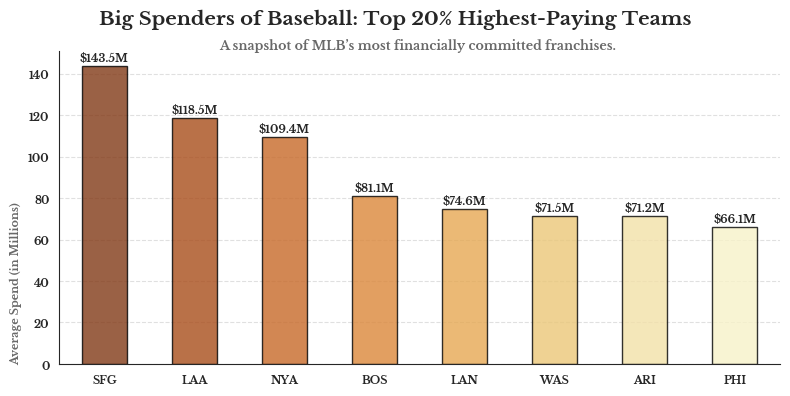

In [55]:
# Initialize figure layout
fig, ax = plt.subplots(figsize=(8, 4))

# Title
fig.suptitle("Big Spenders of Baseball: Top 20% Highest-Paying Teams", ha="center", font=font_bold, fontsize=14)

# Subtitle
fig.text(0.28, 0.88, "A snapshot of MLB’s most financially committed franchises.", fontsize=9, color="dimgrey", font=font_bold)

# Plot customized bar plot
custom_barplot(df=df_top_spenders, x_axis="team", y_axis="avg_spend_in_mil", 
               hue="team", y_label="Average Spend (in Millions)", annote=False)

# Add value labels
for index, value in enumerate(df_top_spenders["avg_spend_in_mil"]):
    ax.text(x=index, y=value + 1, s=f"${value:.1f}M", ha='center', va="bottom", font=font_bold, fontsize=8, weight='bold')

plt.show()

Among the top 20% of MLB teams by average payroll, the **San Francisco Giants (SFG) lead by a significant margin**, averaging $143.5 million. They are followed by the **Los Angeles Angels (LAA)** and **New York Yankees (NYA)**. These high-spending franchises likely benefit from robust financial resources and prioritize acquiring top-tier talent through substantial contracts.

---
### 4.2 Teams' Cumulative Spending Over Time
To understand long-term financial commitment, we examine how MLB teams’ total salary spending has accumulated across seasons. 

***SQL Query:***
```sql
-- Calculate each team's cumulative salary spending over the years (in millions)
SELECT teamid AS team, yearid AS year, 
	   ROUND(SUM(total_spend_yr) OVER 
	   (PARTITION BY teamid ORDER BY yearid) / 1000000, 1) AS cumulative_sum_in_mil
FROM team_annual
ORDER BY teamid, yearid;

***Query Result:***

In [59]:
# Run query and preview result
df_team_cumulative_spend = load_sql_query("4.2_team_cumulative_spend")
preview_table(df_team_cumulative_spend, "df_team_cumulative_spend")

**Preview of `df_team_cumulative_spend`:**

,team,year,cumulative_sum_in_mil
0,ANA,1997,31.1
1,ANA,1998,72.4
...,...,...,...
858,WAS,2013,583.4
859,WAS,2014,715.4


Before visualizing, we isolate the **top 5 teams** with the highest total salary investment to focus the analysis on franchises with the largest long-term spending footprints.

In [61]:
# Get cumulative salary for each team
team_salary_cum = salaries.pivot_table(values='salary', index='teamid', aggfunc='sum').sort_values(ascending=False, by='salary')

# Filter top 5 teams
top_teams = team_salary_cum.head(5).index.values
filtered_df = df_team_cumulative_spend[df_team_cumulative_spend['team'].isin(top_teams)]

In [62]:
df_team_cumulative_spend

,team,year,cumulative_sum_in_mil
0,ANA,1997,31.1
1,ANA,1998,72.4
2,ANA,1999,127.8
3,ANA,2000,179.3
4,ANA,2001,226.8
...,...,...,...
855,WAS,2010,325.0
856,WAS,2011,388.8
857,WAS,2012,469.7
858,WAS,2013,583.4


### 💡 Cumulative Spending Insights:

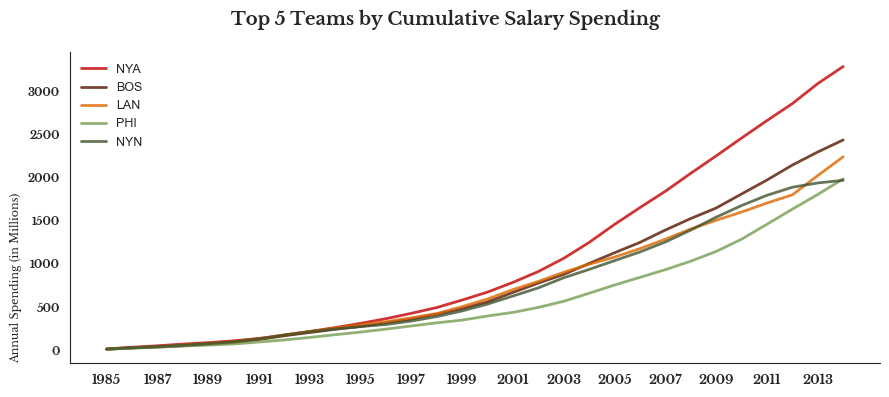

In [64]:
# Initialize layout and visualize a bar plot
fig, ax = plt.subplots(figsize=(9, 4))

# Stacked Line plot
sns.lineplot(data=filtered_df, x="year", y="cumulative_sum_in_mil", hue="team", 
             hue_order=top_teams, palette=palette_qualitative[:5], linewidth=2.0, alpha=0.8)

# Title
fig.suptitle("Top 5 Teams by Cumulative Salary Spending", ha="center", font=font_bold, fontsize=13)

# Subtitle
fig.text(0.30, 0.88, "", fontsize=9, color='dimgrey', font=font_bold)

# Axis and Labels
plt.legend(loc="upper left", edgecolor="white", fontsize=9)
plt.ylabel('Annual Spending (in Millions)', font=font_regular, fontsize=8, loc="bottom")
plt.xlabel("")
plt.xticks(range(filtered_df['year'].min(), filtered_df['year'].max(), 2), font=font_bold, size=9)
plt.yticks(font=font_bold, size=8)

plt.tight_layout()
plt.show()

The **New York Yankees (NYA)** have led cumulative salary spending, with a sharp takeoff starting in the 2000s that sets them apart from the rest.

**Boston Red Sox (BOS), Los Angeles Dodgers (LAN)**, and **New York Mets (NYN)** follow behind with relatively similar trajectories. 

In contrast, the **Philadelphia Phillies (PHI)** show a more gradual and steady rise in cumulative salary spending, with fewer fluctuations over the years. This reflects differing financial strategies and team-building philosophies across franchises.

---
### 4.3 MLB Teams Crossing the \$1B Cumulative Spend Milestone
This section tracks a key financial milestone in MLB history—the moment when each team first surpassed $1 billion in cumulative salary spending. By analyzing year-over-year payroll data, we identify which franchises crossed this threshold earliest, shedding light on financial leadership in the league.

***SQL Query:***
```sql
-- Cumulative spend (in millions) per team across years
WITH team_cumulative AS (
	SELECT teamid, yearid, 
			ROUND(SUM(total_spend_yr) OVER 
			(PARTITION BY teamid ORDER BY yearid) / 1000000, 1) AS cumulative_sum_in_mil
	FROM team_annual
),
-- First year each team crosses $1 billion cumulative spend
year_ranking AS (
	SELECT *, FIRST_VALUE(yearid) OVER (PARTITION BY teamid ORDER BY yearid) AS yr_1_bil
	FROM team_cumulative
	WHERE cumulative_sum_in_mil > 1000
	ORDER BY teamid, yearid)
    
-- Year where each team hit the $1B threshold
SELECT teamid, yr_1_bil, ROUND(cumulative_sum_in_mil / 1000, 2) AS cumulative_sum_in_bil
FROM year_ranking
WHERE yearid = yr_1_bil;

***Query Result:***

In [68]:
# Run query and preview result
df_one_billion_threshold = load_sql_query("4.3_one_billion_threshold")
preview_table(df_one_billion_threshold, "df_one_billion_threshold")

**Preview of `df_one_billion_threshold`:**

,teamid,yr_1_bil,cumulative_sum_in_bil
0,ARI,2012,1.02
1,ATL,2005,1.07
...,...,...,...
24,TEX,2007,1.04
25,TOR,2008,1.05


Before visualizing, We generate the frequency distribution of teams reaching \$1 Billion and the earliest teams to reach this historic milestone (by 2007).

In [70]:
# Calculate frequency of first $1B milestones by year
df_year_count = df_one_billion_threshold['yr_1_bil'].value_counts().sort_index()

# Identify early spenders
early_spenders = df_one_billion_threshold[df_one_billion_threshold['yr_1_bil'] <= 2007]
early_spenders_jittered = early_spenders.copy()

# Apply small manual y-offsets to overlapping points
overlapping_teams = ['SEA', 'SFN', 'TEX']
offsets = [-0.0025, 0, 0.0025]  # Slight manual jitter
for team, offset in zip(overlapping_teams, offsets):
    early_spenders_jittered.loc[early_spenders_jittered['teamid'] == team, 'cumulative_sum_in_bil'] += offset

### 💡 \$1B Milestone Insights:

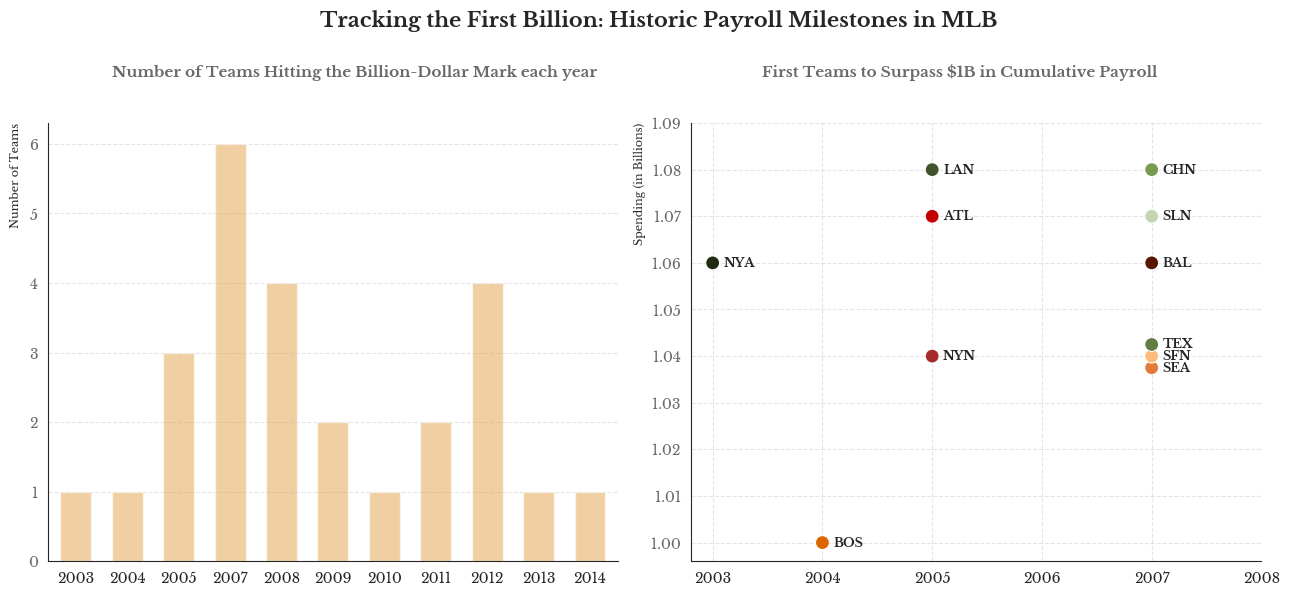

In [495]:
# Initialize subplots layout
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

# Bar Plot (Frequency Distribution)
df_year_count.plot.bar(color=palette_core["primary_light"], width=0.6, alpha=0.5, ax=ax1)
ax1.grid(axis="y", linestyle="--", alpha=0.5)

# Bar plot axis and labels
ax1.set_xlabel("")
ax1.set_ylabel("Number of Teams", font=font_regular, fontsize=8, loc="top")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0, font=font_regular, fontsize=10)
ax1.set_yticks(range(0, 7, 1))
ax1.set_yticklabels(ax1.get_yticklabels(), font=font_regular, fontsize=10, color="dimgrey")

# Scatter Plot
sns.scatterplot(data=early_spenders_jittered, x="yr_1_bil", y="cumulative_sum_in_bil", 
                hue="teamid", palette=palette_qualitative[:11], s=100, legend=False, ax=ax2)
ax2.grid(True, linestyle='--', alpha=0.5)

# Scatter plot axis and labels
ax2.set_xlabel("")
ax2.set_ylabel("Spending (in Billions)", font=font_regular, fontsize=8, loc="top")
ax2.set_xticks(range(2003, 2009, 1))
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0, font=font_regular, fontsize=10)
ax2.set_yticks(np.arange(1.00, 1.09, 0.01))
ax2.set_yticklabels(ax2.get_yticklabels(), font=font_regular, fontsize=10, color="dimgrey")

# Add labels to each scatter point
for i in range(early_spenders_jittered.shape[0]):
    ax2.text(early_spenders_jittered['yr_1_bil'].iloc[i] + 0.1, 
             early_spenders_jittered['cumulative_sum_in_bil'].iloc[i], 
             early_spenders_jittered['teamid'].iloc[i], fontsize=9, font=font_bold, ha='left', va='center')


# Figure Titles
fig.text(0.25, 1.15, "Tracking the First Billion: Historic Payroll Milestones in MLB", fontsize=15, font=font_bold)
fig.text(0.09, 1.05, "Number of Teams Hitting the Billion-Dollar Mark each year", fontsize=11, color="dimgrey", font=font_bold)
fig.text(0.59, 1.05, "First Teams to Surpass $1B in Cumulative Payroll", fontsize=11, color="dimgrey", font=font_bold)

plt.tight_layout()
plt.show()

The year **2007 stands out** as a pivotal moment in MLB financial history, with **six teams** surpassing the \$1 billion cumulative spending mark—the most of any single year. This suggests a broader shift in league-wide spending patterns, possibly driven by escalating player salaries or strategic investment during that time.

Following closely, **2008 and 2012** each saw **four teams** join the billion-dollar club, while 2005 marked the milestone for three teams.

Leading the charge, the **New York Yankees (NYA)** became the **first team** to cross the \$1 billion threshold in **2003**, reaching \$1.06 billion in total spend. The **Boston Red Sox (BOS)** followed in **2004**, hitting exactly \$1.00 billion—highlighting the early financial dominance of these powerhouse franchises.

---
## 5. Career Analysis
In this section, we explore the career history of MLB players.

We begin by viewing the key career fields: `playerid`, `birthyear`, `namegiven`, `debut`, `finalgame`, and total number of players.

In [75]:
players_subset = players[['playerid', 'birthyear', 'birthmonth', 'birthday', 'namegiven', 'debut', 'finalgame']]
preview_table(players_subset, "players_subset")

**Preview of `players_subset`:**

,playerid,birthyear,birthmonth,birthday,namegiven,debut,finalgame
0,aardsda01,1981.0,12.0,27.0,David Allan,2004-04-06,2013-09-28
1,aaronha01,1934.0,2.0,5.0,Henry Louis,1954-04-13,1976-10-03
...,...,...,...,...,...,...,...
18587,zuverge01,1924.0,8.0,20.0,George,1951-04-21,1959-06-15
18588,zwilldu01,1888.0,11.0,2.0,Edward Harrison,1910-08-14,1916-07-12


### 📑 Section Goals**
We aim to answer the following questions:

-  **5.1 Career Span Analysis:**  
   Analyze career length: How long did players' careers last? At what age did they debut and retire?

-  **5.2 Player Retention Across Teams:**  
   Identify teams played by each player over time. Find players who started and ended their career on the same team and played for over a decade and teams with historically higher player retention.

## 5.1 Career Span Analysis:
In this section, we examine how long players' careers lasted, along with their debut and retirement ages.

***SQL Query:***
```sql
-- Create a temporary table with additional career fields
CREATE TEMPORARY TABLE IF NOT EXISTS career_info AS (
    SELECT playerid, birthyear, birthmonth, birthday, namegiven, debut, finalgame, 
           EXTRACT(YEAR FROM debut) AS debut_year,
           EXTRACT(YEAR FROM finalgame) AS final_year
    FROM players
);

-- Calculate career length, debut age, and retirement age
SELECT playerid, namegiven, 
       final_year - debut_year AS career_length,
       debut_year - birthyear AS start_age,
       final_year - birthyear AS end_age
FROM career_info
WHERE final_year - debut_year IS NOT NULL AND debut_year - birthyear > 0
ORDER BY career_length DESC;

***Query Result:***

In [79]:
# Run query and preview result
df_career_span = load_sql_query("5.1_career_span")
preview_table(df_career_span, "df_career_span")

**Preview of `df_career_span`:**

,playerid,namegiven,career_length,start_age,end_age
0,altroni01,Nicholas,35.0,22.0,57.0
1,orourji01,James Henry,32.0,22.0,54.0
...,...,...,...,...,...
18256,zinsebi01,William Francis,0.0,26.0,26.0
18257,zoccope01,Peter Jude,0.0,26.0,26.0


### 🔍 Career Span Insights:


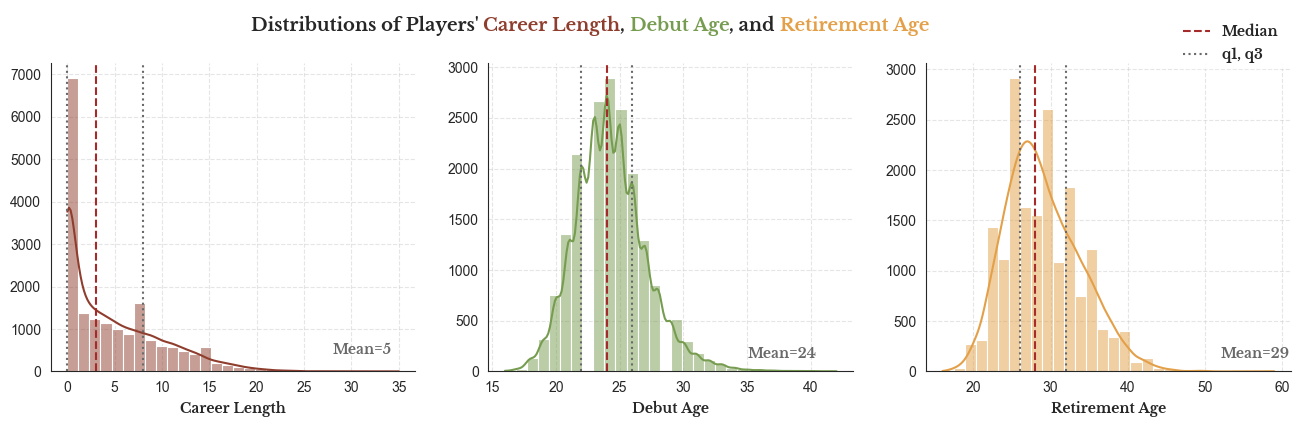

In [81]:
# Initialize figure layout
fig, axes = plt.subplots(1, 3, figsize=(16, 4)) 
color_map = [palette_qualitative[12], palette_qualitative[3], palette_qualitative[13]]

# Set axis and labels
col_map = {0: "career_length", 1: "start_age", 2: "end_age"}
xlabel_map = {0: "Career Length", 1: "Debut Age", 2: "Retirement Age"}
ylabel = ("Number of players" if i == 0 else "")

for i, ax in zip(range(0, 3), axes):   
    # Plot side-by-side histograms
    sns.histplot(df_career_span[col_map[i]], bins=30, kde=True, color=color_map[i], ax=axes[i])
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.set_xlabel(xlabel_map[i], font=font_bold, fontsize=10)
    ax.set_ylabel(ylabel, font=font_bold, fontsize=9, loc="bottom")

    col = df_career_span[col_map[i]]
    # Draw vertical lines for q1, median, and q3
    ax.axvline(col.median(), color=palette_core["avline"], linestyle="--", label="Median")
    ax.axvline(col.quantile(0.25), color=palette_core["secondary_gray"], linestyle=":", label=None)
    ax.axvline(col.quantile(0.75), color=palette_core["secondary_gray"], linestyle=":", label="q1, q3")

    # Show the mean
    pad = (450 if i == 0 else 0)
    ax.text(x=col.max()-7, y=250 + pad, va="top", ha="left", font=font_bold, color=palette_core["secondary_gray"],
            s=f"Mean={round(col.mean(), 0).astype("int")}")

axes[2].legend(bbox_to_anchor=(1.0, 1.17), edgecolor="white", prop=font_bold)

# Title
title = "Distributions of Players' <Career Length>, <Debut Age>, and <Retirement Age>"
fig_text(x=0.25, y=1.0, s=title, fontsize=13, fontproperties=font_bold,
         highlight_textprops=[{"color": color_map[0]}, {"color": color_map[1]}, {"color": color_map[2]}])

plt.show()

**Average Career Length (Right-Skewed):**
- The typical MLB career spans **just 3 years**, reflecting the league’s high competition and turnover.
- While some rare cases extend up to 35 years, **75%** of players have careers lasting **8 years or less.**
- Notably, **nearly 7,000** players exited the league after **just 1 year or less**, highlighting the fleeting nature of many professional baseball careers.

**Debut and Retirement Ages (Bell-Curved):**

- Most players **debut around age 24** and **retire near age 29**, following a relatively narrow age window.
- Outliers include early debuts at age 16 or careers stretching to age 42.
- By age **28**, roughly **half of all players** have already concluded their careers.

---
### 5.2 Player Retention Across Teams
This section explores player loyalty and mobility across Major League Baseball teams. Specifically, we identify which team each player debuted and retired with, and investigate which teams have demonstrated the strongest player retention over time.

***SQL Query:***
```sql
-- Step 1: Get basic player info and calculate debut and final years
WITH career_info AS (
    SELECT playerid, birthyear, birthmonth, birthday, namegiven, debut, finalgame,
           EXTRACT(YEAR FROM debut) AS debut_year,
           EXTRACT(YEAR FROM finalgame) AS final_year
    FROM players
)

-- Step 2: Determine each player's debut and final team using window functions
SELECT *,
       FIRST_VALUE(teamid) OVER (PARTITION BY playerid ORDER BY yearid) AS debut_team,
       FIRST_VALUE(teamid) OVER (PARTITION BY playerid ORDER BY yearid DESC) AS final_team,
       ROW_NUMBER() OVER (PARTITION BY playerid ORDER BY yearid ASC) AS row_num
FROM (
    -- Step 2a: Join player info with salary records to capture year-by-year team associations
    SELECT ci.playerid, ci.namegiven, ci.debut_year, ci.final_year, s.yearid, s.teamid
    FROM career_info AS ci
    LEFT JOIN salaries AS s
      ON ci.playerid = s.playerid
    WHERE s.teamid IS NOT NULL
) AS player_team_history
ORDER BY playerid, yearid;



***Query Result:***

In [85]:
# Run query and preview result
df_team_history = load_sql_query("5.2_team_history")
preview_table(df_team_history, "df_team_history")

**Preview of `df_team_history`:**

,playerid,namegiven,debut_year,final_year,yearid,teamid,debut_team,final_team,row_num
0,aardsda01,David Allan,2004.0,2013.0,2004,SFN,SFN,NYA,1
1,aardsda01,David Allan,2004.0,2013.0,2007,CHA,SFN,NYA,2
...,...,...,...,...,...,...,...,...,...
24751,zupcibo01,Robert,1991.0,1994.0,1993,BOS,BOS,BOS,3
24752,zuvelpa01,Paul,1982.0,1991.0,1989,ATL,ATL,ATL,1


### 🔍 Insight: Team Loyalty vs. Movement Patterns

By analyzing each player’s debut team and final team, we gain insights into patterns of player loyalty and team retention. Specifically, we focus on players whose careers spanned more than 5 years, filtering out short-term players to better highlight long-term affiliations.

Next, we aggregate the loyal vs. non-loyal players per team to calculate the retension rate and identify which teams historically retained their players most effectively.

In [87]:
# Filter for long-term players (career > 5 years)
df_long_term = df_team_history[
    (df_team_history["final_year"] - df_team_history["debut_year"] > 5) &
    (df_team_history["row_num"] == 1)
].copy()

# Flag loyal players
df_long_term["is_loyal_player"] = np.where(
    df_long_term["debut_team"] == df_long_term["final_team"], "loyal", "not_loyal"
)

# Count loyal vs non-loyal players per debut team
team_loyalty_counts = (
    df_long_term.groupby(["debut_team", "is_loyal_player"])["playerid"]
    .nunique()
    .unstack(fill_value=0)
    .rename_axis("team")
    .reset_index()
)

# Compute retention rate
team_loyalty_counts["retention_rate"] = round(
    team_loyalty_counts["loyal"] / (team_loyalty_counts["loyal"] + team_loyalty_counts["not_loyal"]), 2
)

# Sort by retention rate
df_team_retention = team_loyalty_counts.sort_values("retention_rate", ascending=False)

# Get Top & Bottom teams
combined = pd.concat([
    df_team_retention.nlargest(5, "retention_rate").assign(Group="Top"),
    df_team_retention.nsmallest(5, "retention_rate").assign(Group="Bottom")
])

Next, we visualize:
1. The overall distribution of team retention rates
2. A comparison of the top and bottom teams by retention performance.

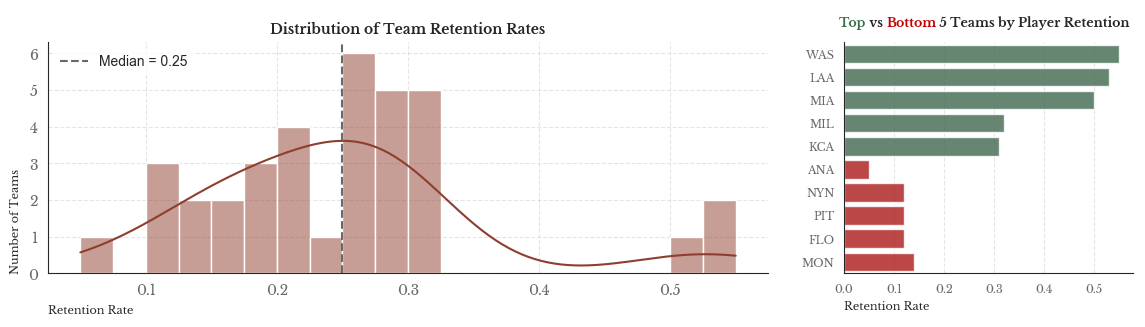

In [501]:
# Setup layout
fig = plt.figure(figsize=(14, 3))
gs = gridspec.GridSpec(1, 2, width_ratios=[2.5, 1], wspace=0.15)

# --- Plot 1: Distribution of Retention Rates ---
ax0 = plt.subplot(gs[0])
sns.histplot(df_team_retention, x="retention_rate", bins=20, kde=True, color=palette_core["primary_dark"], ax=ax0)
ax0.grid(True, linestyle="--", alpha=0.5)
ax0.axvline(df_team_retention["retention_rate"].median(), color=palette_core["secondary_gray"], linestyle="--", 
            label=f"Median = {df_team_retention["retention_rate"].median()}")

# Axis and labels
ax0.set_title("Distribution of Team Retention Rates", fontsize=15, fontproperties=font_bold)
ax0.set_xlabel("Retention Rate", fontsize=8, fontproperties=font_regular, loc="left")
ax0.set_ylabel("Number of Teams", fontsize=8, fontproperties=font_regular, loc="bottom")
ax0.set_yticks(range(0, 7))
ax0.tick_params(axis='both', labelsize=10)
for label in ax0.get_xticklabels() + ax0.get_yticklabels():
    label.set_fontproperties(font_regular)
    label.set_color("dimgrey")
ax0.legend(edgecolor="white", loc="upper left")

# --- Plot 2: Top vs Bottom 5 Teams ---
ax1 = plt.subplot(gs[1])
palette = {"Top": palette_core["highlight_green"], "Bottom": palette_core["highlight_red"]}
sns.barplot(data=combined, y="team", x="retention_rate", hue="Group", dodge=False, palette=palette, ax=ax1, alpha=0.8, legend=False)
ax1.grid(axis="x", linestyle="--", alpha=0.5)

fig_text(
    x=0.69, y=0.97, s="<Top> vs <Bottom> 5 Teams by Player Retention", fontsize=9, fontproperties=font_bold,
    highlight_textprops=[{"color": palette["Top"]}, {"color": palette["Bottom"]}]
)

ax1.set_xlabel("Retention Rate", fontsize=8, fontproperties=font_regular, loc="left")
ax1.set_ylabel("")
ax1.tick_params(axis='both', labelsize=8)
for label in ax1.get_xticklabels() + ax1.get_yticklabels():
    label.set_fontproperties(font_regular)
    label.set_color("dimgrey")
    label.set_fontsize(8)

plt.show()

Out of **2,669 long-term players**, only **611** (~23%) ended their careers with their debut team. The median retention rate across teams is just **25%**, meaning most teams retain one in four long-term players or fewer.

- **Top Teams:** WAS (**55%**), LAA (**53%**), MIA (**50%**)

- **Lowest:** ANA with only **5%**, while others in the bottom tier range from **12%–14%**

These figures highlight stark differences in how well teams retain long-term players — potentially influenced by franchise culture, performance trends, or management strategy.

---
## 6. Players Comparision Analysis
In this section, we compare players based on playing styles and attributes (heigh, weight) to uncover trends and similarities.
Let's view important player attributes such as weight, height, batting side (`bats`), and throwing hand (`throws`).

In [92]:
columns = ['playerid', 'namegiven','weight', 'height', 'bats', 'throws']
preview_table(players[columns], "players_subset")

**Preview of `players_subset`:**

,playerid,namegiven,weight,height,bats,throws
0,aardsda01,David Allan,205.0,75.0,R,R
1,aaronha01,Henry Louis,180.0,72.0,R,R
...,...,...,...,...,...,...
18587,zuverge01,George,195.0,76.0,R,R
18588,zwilldu01,Edward Harrison,160.0,66.0,L,L


### 📑 Section Goals
We aim to answer the following questions:

-  **6.1 Batting and Throwing Preferences:**  
   Create summary tables for each team showing the percentage of players who bat right, left, or both, and the same for throwing handedness.

-  **6.2 Height and Weight Trends:**  
   Analyze how average debut height and weight have changed over the years, and compare decade-over-decade differences.

### 6.1 Batting and Throwing Preferences
***SQL Query:***

```sql
WITH sum_stats AS (
    SELECT 
        s.teamid,
        -- Count of players who bat both, left, or right-handed
        COUNT(DISTINCT CASE WHEN p.bats = 'B' THEN p.playerid ELSE NULL END) AS bat_both,
        COUNT(DISTINCT CASE WHEN p.bats = 'L' THEN p.playerid ELSE NULL END) AS bat_left,
        COUNT(DISTINCT CASE WHEN p.bats = 'R' THEN p.playerid ELSE NULL END) AS bat_right,
        
        -- Count of players who throw left or right-handed
        COUNT(DISTINCT CASE WHEN p.throws = 'L' THEN p.playerid ELSE NULL END) AS throw_left,
        COUNT(DISTINCT CASE WHEN p.throws = 'R' THEN p.playerid ELSE NULL END) AS throw_right,
        
        -- Total unique players per team
        COUNT(DISTINCT p.playerid) * 1.0 AS total
    FROM players AS p
    LEFT JOIN salaries AS s ON p.playerid = s.playerid
    WHERE teamid IS NOT NULL
    GROUP BY s.teamid
)

-- Calculate batting and throwing percentages per team
SELECT COALESCE(teamid, 'N/A') AS team,
        ROUND(bat_both/total * 100, 2) AS bat_both_pct,
        ROUND(bat_left/total * 100, 2) AS bat_left_pct,
        ROUND(bat_right/total * 100, 2) AS bat_right_pct,
        ROUND(throw_left/total * 100, 2) AS throw_left_pct,
        ROUND(throw_right/total * 100, 2) throw_right_pct
FROM sum_stats;


***Query Result:***

In [96]:
# Run query and preview result
df_bat_throw_preference = load_sql_query("6.1_bat_throw_preference")
preview_table(df_bat_throw_preference, "df_bat_throw_preference")

# Descriptive Stats
df_preference_stats = df_bat_throw_preference.describe().loc[['mean', 'max','50%', '75%']]
preview_table(df_preference_stats, "df_preference_stats")

**Preview of `df_bat_throw_preference`:**

,team,bat_both_pct,bat_left_pct,bat_right_pct,throw_left_pct,throw_right_pct
0,ANA,9.09,24.55,66.36,17.27,82.73
1,ARI,9.01,29.61,61.37,21.89,78.11
...,...,...,...,...,...,...
35,TOR,9.25,25.37,65.37,18.81,81.19
36,WAS,10.43,28.22,61.35,21.47,78.53


**Preview of `df_preference_stats`:**

,bat_both_pct,bat_left_pct,bat_right_pct,throw_left_pct,throw_right_pct
mean,9.494865,27.857027,62.647297,21.16027,78.84
max,18.52,32.13,68.6,25.0,87.5
...,...,...,...,...,...
50%,9.35,28.22,63.02,21.27,78.73
75%,10.5,29.17,63.73,23.06,79.94


### 🔍 Insight: Batting and Throwing Preferences

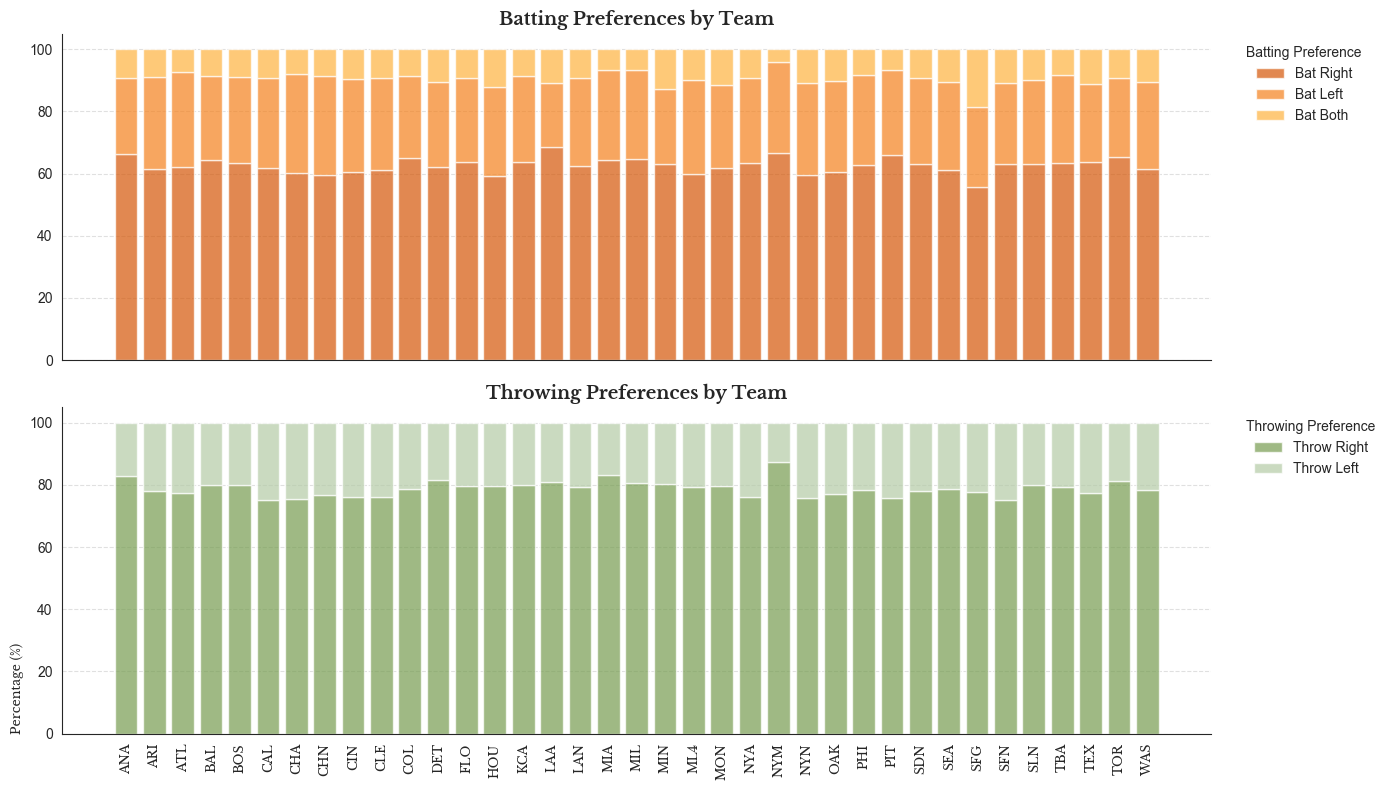

In [489]:
# Separate into two batting anf throwing DataFrames
batting_df = df_bat_throw_preference.set_index('team')[['bat_right_pct', 'bat_left_pct', 'bat_both_pct']].sort_index()
throwing_df = df_bat_throw_preference.set_index('team')[['throw_right_pct', 'throw_left_pct']].sort_index()

# Helper function for stacked bar plot
def plot_stacked_bar(ax, df, colors, item, title, legend_title):
    bottom = pd.Series([0] * len(df), index=df.index)
    for i, col in zip(range(0, item, 1), df.columns.values):
        ax.bar(df.index, df[col], bottom=bottom, label=col.replace("_pct", "").replace("_", " ").title(), color=colors[i], alpha=0.7)
        bottom += df[col]
    ax.set_title(title, font=font_bold, fontsize=13)
    ax.legend(title=legend_title, bbox_to_anchor=(1.02, 1), loc="upper left", edgecolor="white")
    ax.grid(axis="y", linestyle="--", alpha=0.6)

# Create plots
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

plot_stacked_bar(axes[0], batting_df, palette_sequential[1:], 3, "Batting Preferences by Team", "Batting Preference")
plot_stacked_bar(axes[1], throwing_df, [palette_qualitative[3], palette_qualitative[15]], 2, "Throwing Preferences by Team", "Throwing Preference")
axes[1].set_ylabel("Percentage (%)", font=font_regular, fontsize=9, loc="bottom")

# Set_ticks before set_ticklabels
ticks = list(throwing_df.index)
for ax in axes:
    ax.set_xticks(range(len(ticks)))
    ax.set_xticklabels(ticks, rotation=90, font=font_regular, fontsize=9)

plt.tight_layout()
plt.show()

The trend is clear—most players prefer right-handed batting and throwing. On average, teams have **63% right-handed batters, 28% left-handed**, and **9% switch hitters**. Throwing preferences are even stronger: **79% of players throw right-handed**, with only **21% throwing left** on average. While batting styles show noticeable variation across teams, **throwing preferences are more uniform**, with 80% of teams having right-handed throwers make up at least 75% of their roster.

### 5.3 Height and Weight Trends Over Decades
***SQL Query:***

```sql
WITH avg_hw AS (
	SELECT FLOOR(EXTRACT(YEAR FROM debut) / 10) * 10 AS decade, 
			ROUND(AVG(height)) AS avg_height_inches, ROUND(AVG(weight)) AS avg_weight_lbs
	FROM players
	GROUP BY FLOOR(EXTRACT(YEAR FROM debut) / 10) * 10)

SELECT  decade::INT, avg_height_inches,
		avg_height_inches - LAG(avg_height_inches) OVER (ORDER BY decade) AS height_diff,
		avg_weight_lbs,
		avg_weight_lbs - LAG(avg_weight_lbs) OVER (ORDER BY decade) AS weight_diff
FROM avg_hw
WHERE decade IS NOT NULL
ORDER BY decade;

***Query Result:***

In [102]:
# Run query and preview result
df_height_weight_stats = load_sql_query("6.2_height_weight_stats")
preview_table(df_height_weight_stats, "df_height_weight_stats")

**Preview of `df_height_weight_stats`:**

,decade,avg_height_inches,height_diff,avg_weight_lbs,weight_diff
0,1870,69.0,NaN,163.0,NaN
1,1880,70.0,1.0,169.0,6.0
...,...,...,...,...,...
13,2000,74.0,1.0,206.0,12.0
14,2010,74.0,0.0,207.0,1.0


In [103]:
df_summary_stats = df_height_weight_stats[['height_diff', 'weight_diff']].describe()
df_summary_stats.loc[['mean', '25%', '50%', '75%', 'min', 'max']]

,height_diff,weight_diff
mean,0.357143,3.142857
25%,0.000000,1.000000
50%,0.000000,2.000000
75%,1.000000,5.500000
min,0.000000,-2.000000
max,1.000000,12.000000


### 🔍 Insights: Height and Weight Trends

**Height trends are stable and gradual:**

- Average decade-over-decade change is only **0.35 inches**, with the **maximum difference being 1 inch** between any two decades.
- This suggests that player height remained largely consistent, **increasing slowly and steadily** over time.
- Increases tend to occur in 1-inch steps that hold steady across multiple decades.

**Weight trends show greater variation and fluctuations:**

- The average decade-over-decade difference is **3.14 lbs**, with 75% of differences ≤ 5.5 lbs.
- There are notable **spikes**, such as a **12 lb increase in the 2000s**, followed by a continued 2 lb increase in the 2010s.
- The overall trend moves upward from **163 lbs in 1870 to nearly 207 lbs in 2010**, but with periodic dips and surges.

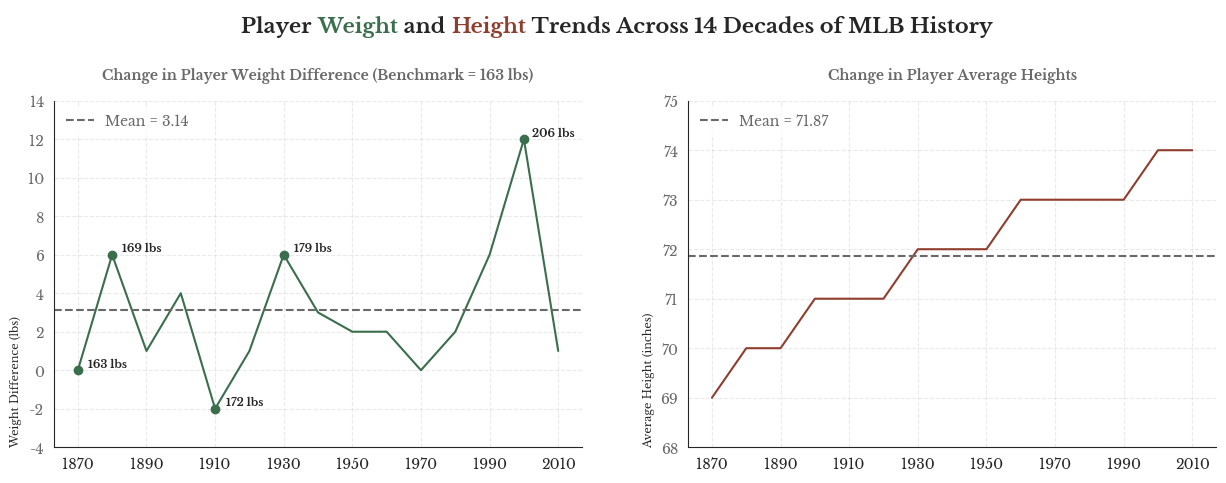

In [410]:
# Setup
fig, axes = plt.subplots(1, 2, figsize=(15, 4.5))
color_map = [palette_core["highlight_green"], palette_core["primary_dark"]]

#[palette_qualitative[12], palette_qualitative[3], palette_qualitative[13]]

# Define column-to-label mapping
col_map = {0: "weight_diff", 1: "avg_height_inches"}
ylabel_map = {0: "Weight Difference (lbs)", 1: "Average Height (inches)"}
title_map = {0: "Change in Player Weight Difference (Benchmark = 163 lbs)", 1: "Change in Player Average Heights"}

# Decades to annotate
annote_decades = [1870, 1880, 1910, 1930, 2000]

# Loop through the two line plots
for i, ax in zip(range(2), axes):
    col = col_map[i]
    color = color_map[i]
    mean_val = round(df_height_weight_stats[col].mean(), 2)

    # Lineplot
    sns.lineplot(data=df_height_weight_stats.fillna(0), x="decade", y=col, ax=ax, color=color, linewidth=1.5)
    ax.axhline(mean_val, color=palette_core["secondary_gray"], linestyle="--", label=f"Mean = {mean_val}")

    # Annotate select decades (only for weight)
    if col == "weight_diff":
        for _, row in df_height_weight_stats[df_height_weight_stats["decade"].isin(annote_decades)].fillna(0).iterrows():
            ax.text(row["decade"] + 8.5, row[col], f"{int(row['avg_weight_lbs'])} lbs",
                    ha="center", va="bottom", fontproperties=font_bold, fontsize=8)
            ax.scatter(row["decade"], row[col], color=color)

    # Axes settings
    ax.set_xticks(range(1870, 2020, 20))
    ax.set_xticklabels(range(1870, 2020, 20), fontproperties=font_regular, fontsize=10)
    ax.set_yticks(ax.get_yticks())
    ax.set_yticklabels([int(t) for t in ax.get_yticks()], fontproperties=font_regular, fontsize=10, color="dimgray")
    

    ax.set_xlabel("")
    ax.set_ylabel(ylabel_map[i], fontproperties=font_regular, fontsize=8, loc="bottom")
    ax.set_title(title_map[i], color="dimgray", fontsize=11, font=font_bold, loc="center", pad=15)
    ax.grid(True, linestyle="--", alpha=0.4)
    ax.legend(loc="upper left", edgecolor="white", fontsize=7, prop=font_regular, labelcolor="dimgray")

# Title
fig_text(
    x=0.25, y=1.07, s="Player <Weight> and <Height> Trends Across 14 Decades of MLB History",
    fontsize=15, fontproperties=font_bold,
    highlight_textprops=[{"color": color_map[0]}, {"color": color_map[1]}]
)

plt.show()

## 4. Concluding Summary
2007 was a landmark year, with a record six teams surpassing $1 billion in total spending, led by early movers like the Yankees and Red Sox.

- Visualization Enhancement and embedde insights into the Viz title: ggplot.
- Standardize quotes
- Refine Insights
- Export as PDF or HTML -- hide code ext
- Color consistency: https://www.atlassian.com/data/charts/how-to-choose-colors-data-visualization
- Overall project flow and fixes